In [11]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from skimage import io
from torchvision.transforms import ToTensor

## BEFORE

In [2]:
path = 'C:/Users/guzma/OneDrive/Documents/TEC/DTU/02456/Project/Github_Project/autotetris/small_sample_out/metadata_sample.hdf'
df = pd.read_hdf(path, '/d')
# centroid=df.iloc[:,6].values
# test = df.building_id.str.split('-b15',n = 1, expand = True)[0].tolist()
centroid = np.array(df.panel_centroids.to_list())

C:\Users\guzma\AppData\Local\Temp\ipykernel_14512\3093259657.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  centroid = np.array(df.panel_centroids.to_list())


In [37]:
class MyDataset(Dataset):
 
  def __init__(self,file_name, transform=None):
    img_df=pd.read_hdf(file_name, '/d')
    img_name=img_df.iloc[:,0] #.str.split('-b15',n = 1, expand = True)[0].tolist()
    centroid=img_df.iloc[:,6].values
    
    self.surface = img_df.iloc[:,4].values
    self.base = img_df.iloc[:,3].values
    self.id = img_name

    self.transform = transform
    self.image_paths = [file_name.split('/meta')[0]+'/'+name+'-b15-otovowms.jpeg' for name in img_name]
    self.label = centroid
 
    # self.x_train=torch.tensor(x,dtype=torch.float32)
    # self.y_train=torch.tensor(y,dtype=torch.float32)
 
  def __len__(self):
    return len(self.label)
   
  def __getitem__(self,idx):
    image_filepath = self.image_paths[idx]
    image = cv2.imread(image_filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    label = self.label[idx]
    if self.transform is not None:
        image = self.transform(image=image)["image"]
    
    return image, label, self.id.iloc[idx]

  def show_centroids(self, idx):
    """Show image with centroids"""
    var = np.array(self.label[idx])
    # var2 = np.array(self.surface[idx])
    var3 = np.array(self.base[idx])
    plt.title(self.id.iloc[idx])
    print(self.id.iloc[idx])
    plt.imshow(io.imread(self.image_paths[idx]))
    plt.scatter(var[:,1], var[:,0], s=10, marker='.', c='r')
    # plt.plot(var2[:,1], var2[:,0], c='k')
    plt.plot(var3[:,1], var3[:,0], c='b')
    plt.plot(var)    # plt.xticks([])
    # plt.yticks([])
    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.show()

In [38]:
myDs=MyDataset('C:/Users/guzma/OneDrive/Documents/TEC/DTU/02456/Project/Github_Project/autotetris/small_sample_out/metadata_sample.hdf')
# train_loader=DataLoader(myDs,batch_size=10,shuffle=False)

In [49]:
df = pd.read_hdf('C:/Users/guzma/OneDrive/Documents/TEC/DTU/02456/Project/Github_Project/autotetris/small_sample_out/metadata_sample.hdf','/d')

In [15]:
myDs.label[0]

[[168, 355],
 [149, 341],
 [178, 343],
 [159, 329],
 [188, 332],
 [169, 318],
 [199, 320],
 [180, 306],
 [209, 309],
 [190, 295],
 [219, 297],
 [200, 283],
 [229, 286],
 [210, 272],
 [260, 252],
 [270, 240],
 [251, 226],
 [280, 229],
 [261, 214],
 [271, 203]]

In [16]:
# image = cv2.imread('C:/Users/guzma/OneDrive/Documents/TEC/DTU/02456/Project/Github_Project/autotetris/small_sample_out/2d5c5e72-bf4a-4e02-8768-5dd987583398-b15-otovowms.jpeg')
image = cv2.imread(myDs.image_paths[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [7]:
a = [[[1,2],[3,4]],[[1,2]]]
b = [[1,2],[3,4]]
if len(a) == 1:
    print(a[0])
else:
    print('array 2d')
print(a)

array 2d
[[[1, 2], [3, 4]], [[1, 2]]]


In [8]:
len(a[0])

2

fa1da4f4-45bc-41f7-983d-cb44949a366d


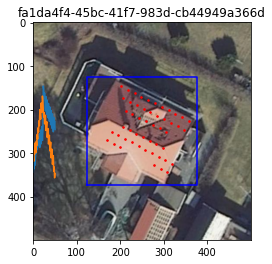

In [11]:
myDs.show_centroids()

In [39]:
image, label, id = myDs.__getitem__(1)

8724d454-483a-4e0d-8e4b-1f45666fd0c6


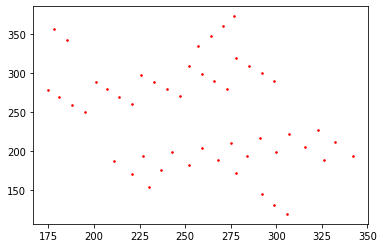

In [67]:
label = np.array(label)
print(id)
plt.scatter(label[:,1], label[:,0], s=10, c='r', marker='.')
# plt.imshow(image)

78a6cd53-5fe9-4a91-b328-be04817f73f1


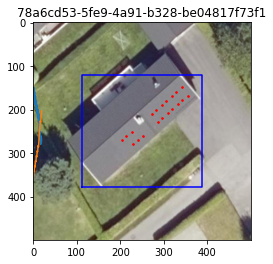

In [68]:
myDs.show_centroids(0)

### ResNet Implementation

In [65]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in myDs[phase]:
                # inputs = inputs.to(device)
                # labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## AFTER

In [60]:
from torchvision import datasets
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import requests
import zipfile
from pathlib import Path

In [8]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("C:/Users/guzma/OneDrive/Documents/TEC/DTU/02456/Project/Github_Project/Dataset")
image_path = data_path / "data_2022-11-01"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory.")

C:\Users\guzma\OneDrive\Documents\TEC\DTU\02456\Project\Github_Project\Dataset\data_2022-11-01 directory exists.


Random image path: C:\Users\guzma\OneDrive\Documents\TEC\DTU\02456\Project\Github_Project\Dataset\data_2022-11-01\3219c2f6-8c00-4c89-81f7-0e2476ef4668-b15-otovowms.jpeg
Image class: data_2022-11-01
Image height: 500
Image width: 500


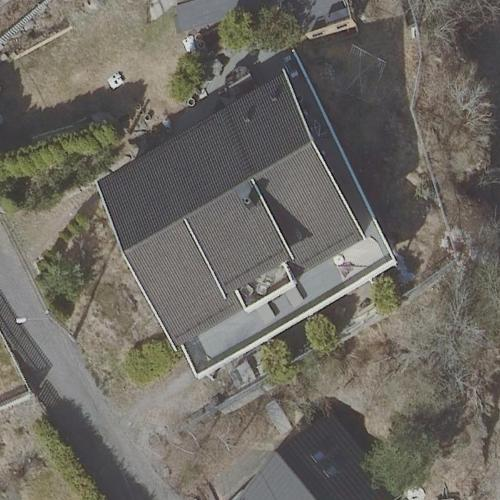

In [57]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*.jpeg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

In [61]:
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(256, 256)),
    # Flip the images randomly on the horizontal
    # transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

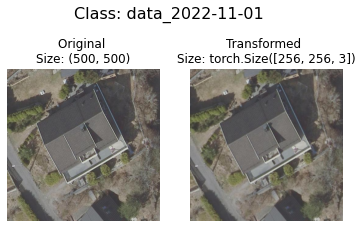

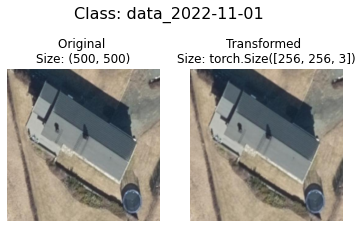

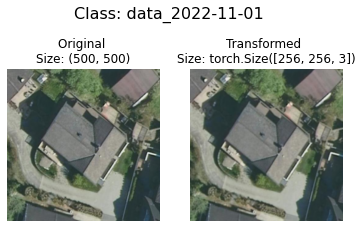

In [63]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

In [64]:
image_path

WindowsPath('C:/Users/guzma/OneDrive/Documents/TEC/DTU/02456/Project/Github_Project/Dataset/data_2022-11-01')

In [66]:
df.iloc[0,6]

[[168, 355],
 [149, 341],
 [178, 343],
 [159, 329],
 [188, 332],
 [169, 318],
 [199, 320],
 [180, 306],
 [209, 309],
 [190, 295],
 [219, 297],
 [200, 283],
 [229, 286],
 [210, 272],
 [260, 252],
 [270, 240],
 [251, 226],
 [280, 229],
 [261, 214],
 [271, 203]]

In [124]:
class RoofPanels(Dataset):
    """Rooftop Centroid dataset."""

    def __init__(self, hdf5_file, root_dir, transform=None):
        """
        Args:
            hdf5 file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.rooftop_frame = pd.read_hdf(hdf5_file,'/d')
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.rooftop_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.rooftop_frame.iloc[idx, 0]+'-b15-otovowms.jpeg')
        image = io.imread(img_name)
        centroid = self.rooftop_frame.iloc[idx, 6]
        centroid = np.array([centroid])
        centroid = centroid.astype('float').reshape(-1, 2)
        sample = {'image': image, 'centroids': centroid}

        if self.transform:
            sample['image'] = self.transform(sample['image'])
            sample['centroids'] = self.transform(sample['centroids'])

        return sample

In [92]:
train_data = RoofPanels(hdf5_file='C:/Users/guzma/OneDrive/Documents/TEC/DTU/02456/Project/Github_Project/autotetris/small_sample_out/metadata_sample.hdf',
                            root_dir=image_path,
                            transform=None) # transforms to perform on labels (if necessary)

# test_data = datasets.ImageFolder(root=test_dir, 
#                                  transform=data_transform)

print(f"Train data:\n{train_data}")

Train data:


In [96]:
n = 65
img_name = df.iloc[n, 0]+'-b15-otovowms.jpeg'
centroids = df.iloc[n, 6]
centroids = np.asarray(centroids)
centroids = centroids.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('centroids shape: {}'.format(centroids.shape))
print('First 4 centroids: {}'.format(centroids[:4]))

Image name: 14e6bf9f-32c8-4e2c-8889-a76f8eec2f52-b15-otovowms.jpeg
centroids shape: (26, 2)
First 4 centroids: [[362. 321.]
 [350. 343.]
 [349. 312.]
 [337. 334.]]


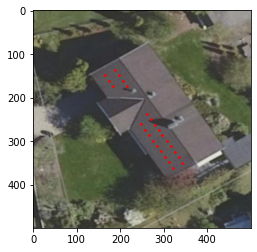

In [97]:
def show_centroids(image, centroids):
    """Show image with centroids"""
    plt.imshow(image)
    plt.scatter(centroids[:, 1], centroids[:, 0], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_centroids(io.imread(os.path.join(image_path, img_name)),
               centroids)
plt.show()

0 (500, 500, 3) (20, 2)


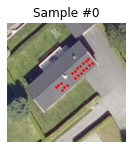

1 (500, 500, 3) (49, 2)


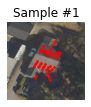

2 (500, 500, 3) (12, 2)


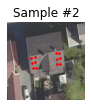

3 (500, 500, 3) (15, 2)


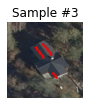

In [99]:
fig = plt.figure(figsize=(8,8))

for i in range(len(train_data)):
    sample = train_data[i]

    print(i, sample['image'].shape, sample['centroids'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_centroids(**sample)

    if i == 3:
        plt.show()
        break

In [101]:
df_path = 'C:/Users/guzma/OneDrive/Documents/TEC/DTU/02456/Project/Github_Project/autotetris/small_sample_out/metadata_sample.hdf'

In [125]:
transformed_dataset = RoofPanels(hdf5_file=df_path,
                                root_dir=image_path,
                                transform=transforms.Compose([
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['centroids'].size())

    if i == 3:
        break

0 torch.Size([3, 500, 500]) torch.Size([1, 20, 2])
1 torch.Size([3, 500, 500]) torch.Size([1, 49, 2])
2 torch.Size([3, 500, 500]) torch.Size([1, 12, 2])
3 torch.Size([3, 500, 500]) torch.Size([1, 15, 2])


In [116]:
transformed_dataset

torch.Size([3, 500, 500])